# Using age, cholestrol, maximum heart rate and resting blood pressure to classify heart disease patients from Cleveland #

**John Mao, Caitlyn Chan and Ritaksha Roy Burman**


### Introduction ###
Cardiovascular heart diseases are the leading cause of death worldwide, accounting for an estimated 17.9 million casualties each year according to the [WHO.](https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1)

Our project seeks to use age, cholesterol, maximum heart rate and resting blood pressure to diagnosis individuals with coronary artery disease, (CAD). CAD occurs when the arteries that deliver blood to the heart is reduced in diameter due to plaque buildup (CDC, 2021).

The goal of this project is to classify patients of whether they have CAD for preventatitive interventions.

The question we wish to answer is: 
**How well can we predict a patient will have coronary artery disease based on age, cholestrol levels, resting blood pressure and maximum heart rate achieved?**

To answer this, we are using the [heart disease](https://archive.ics.uci.edu/dataset/45/heart+disease) database.

We are then comparing this to the Switzerland [switzerland_heart_disease](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data) database.

### Expected Outcomes and Significance ##
We expect to see a positive trend with resting blood pressure and age. We also expect to see that on average, those  with heart diseases will have higher blood pressures.
We wish to explore how sex impacts an individual's potential risk.

This data anaylsis could be advantageous to enhance timely diagnosis of cardiovascular disease to help implement interventions and recognize risk factors. 


In [ ]:
FARIDA # add title for this table

|variable | units | desription |
|-------- | ----- | ---------- |
| chol | mg/dl | serum cholestrol |
| age | years | N/A |
| trestbps | mmHg | resting blood pressure (on admission to hospital) |
| num | N/A | 0 = unafflicted by disease, (1,2,3,4) showing presense of heart disease. |
| thalach | N/A | maximum heart rate achieved (bpm) |
| diagnosis | N/A | Diagnosis will be true or false relating to num |


### Methods ### - TO BE ALTERTED TO FIT OUR REPORT 
1. Preprocessing data
2. split data
3. train data
4. fit modle onto the testing set
5. stats/metrics
7. testing our classifier
8. viz over/underfitting 
9. checking versitlity of the model using ritz swizz
    
We will be using variables from the Heart Disease Database, in particular the Cleaveland database:
- chol : serium cholestoral in mg/dl
- age : age in years
- trestbps : resting blood pressure (in mm Hg on admission to hospital)
- sex
- num : 0 = unafflicted by disease, (1,2,3,4) showing presense of heart disease.
- thalach: maximum heart rate achieved (bpm) 

To tidy the data, we have changed num (presense of heart disease) to factors. **num** uses integers 1 to 4 to determine diagnosis of CAD, thus we have created a new column which sets presence of heart disease (**num** > 0) to TRUE and absence (**num** = 0) to FALSE. 


The dataframe has been split into a training and testing set. The data is stratified by the categorical variable, **diagnosis**. 

To visualize the results of our data analysis, scatterplots of different numerical variables were plotted against eachother. 

* In the plot of **trestbp vs age**

A distinct region of resting blood pressure is high in the ages of 50 to 70. 

* In the plot of **chol vs age**

Women in the ages of 55-65 appear to be at risk whereas men appear to be at risk from ages 45 - 70.

* In the plot of **thalach vs chol**

There are distinct regions of TRUE and FALSE, and a mix of both. 

These relationships and distribution determined selection of **trestbp, age, thalach and chol** as predictors. 

We are going to train and classify using K-nearest neighbours to determine if a new patient is likely to be afflicted by heart disease.




    

### Preliminary exploratory data analysis ###
We have 303 total rows of data amongst our 5 variables with no observations that contain missing data.



**Importing Libraries**

In [1]:
# importing libraries 
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(RColorBrewer)
install.packages("caret")
library(caret)

# formatting tables
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

**Importing and reading the data set from the web**

In [2]:
# cleveland heart data
heart_data <- read_csv("https://archive.ics.uci.edu/static/public/45/data.csv")
# switzerland data
switzerland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = FALSE)


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Cleaning and wrangling the data and splitting the data into training and testing sets**

CAITLYN 
#To add minimal explanation later 

In [3]:
# set the seed 
set.seed(1)

# cleaning and wrangling the data frame, selecting relevant columns
heart_data_clean <- heart_data |>
select(chol, trestbps, age, sex, thalach, num) |>
mutate(diagnosis = as.factor(ifelse(is.na(num), NA, (num>0)))) |>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0")) |>
mutate(num = as_factor(num)) 

# cleaning and wrangling switzerland data frame

colnames(switzerland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

switzerland_data_clean <- switzerland_data |>
select(chol, trestbps, age, sex, thalach, num) |>
mutate(diagnosis = ifelse(is.na(num), NA, (num>0))) |>
mutate(sex = as_factor(sex))|>
mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0")) |>
mutate(num = as_factor(num)) 

# splitting data into training data set and testing data set 
heart_split <- initial_split(heart_data_clean, prop = 0.75, strata = num)

heart_testing <- testing(heart_split)
heart_training <- training(heart_split)

heart_training
print(paste("Total rows", nrow(heart_data_clean)))
print(paste("Rows with missing data", sum(is.na(heart_data_clean))))



chol,trestbps,age,sex,thalach,num,diagnosis
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>
233,145,63,Male,150,0,FALSE
204,130,41,Female,172,0,FALSE
294,140,56,Female,153,0,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮
205,128,55,Female,130,3,TRUE
176,164,59,Male,90,3,TRUE
131,130,57,Male,115,3,TRUE


[1] "Total rows 303"
[1] "Rows with missing data 0"


We felt that a 75/25 split between the training and testing data was a good balance and resulted in sufficient performance.

**Summarizing the Training Data**

Before we visualize and begin our prediction analysis, we need to check that the two predictor classes are balanced so that one class prediction is not favored over the other.

In [4]:
heart_summary_table <- heart_training |>
                    group_by(diagnosis) |>
                    summarize(count = n()) |>
                    arrange(-count)
heart_summary_table

diagnosis,count
<fct>,<int>
FALSE,124
TRUE,102


Based off the above summary table, the counts for TRUE and FALSE heart disease diagnoses are roughly balanced in the training set. 

RITZ **Visualizing the relationships between our chosen predictor variables and the class variable**
#short explanation later 

In [5]:
options(repr.plot.width = 12, repr.plot.height = 5)
# Plot the training data

heart_plot1 <- heart_training |> 
            ggplot(aes(x= age, y= trestbps, color = diagnosis)) +
            geom_point()+ 
            labs(x= "Age", y = "Resting Blood Pressure \n (mm Hg)", fill = "Diagnosis of Heart Disease", color = "Diagnosis of Heart Disease", title = "Resting Blood Pressure versus Age", num = "Diagnosis of Heart Disease")+ # rename false and true 
            theme(text = element_text(size = 12))+
            theme(plot.title = element_text(hjust = 0.5)) +
            scale_color_manual(values = c("darkorange", "steelblue"))

heart_plot2 <- heart_training |>
            mutate(num = ifelse(num == 0, FALSE, TRUE)) |>
            ggplot(aes(x = age, y = chol, color = num)) + 
            geom_point() +
            labs(num = "Diagnosis of Heart Disease",
           color = "Diagnosis of Heart Disease",
           title = "Cholesterol Levels (mg/dl) versus Age based on Sex",
           y = "Cholesterol (mg/dl)", x= "Age (years)") +
            theme(text = element_text(size = 13)) +
            scale_size_discrete(range = c(1, 2)) +
            facet_grid(cols = vars(sex))+
            theme(plot.title = element_text(hjust = 0.5)) +
            scale_color_manual(values = c("darkorange", "steelblue"))

heart_plot3 <- heart_training |> 
            ggplot(aes(x= chol, y= thalach, color = diagnosis)) +
            geom_point()+ 
            labs(x= "Cholestrol (mg/dl)", y = "Maximum heart rate achieved (bpm)", fill = "Diagnosis of Heart Disease", color = "Diagnosis of Heart Disease", title = "Maximum Heart Rate (bpm) versus Cholestrol (mg/dl)", num = "Diagnosis of Heart Disease")+ # rename false and true 
            theme(text = element_text(size = 12)) +
            theme(plot.title = element_text(hjust = 0.5)) +
            scale_color_manual(values = c("darkorange", "steelblue")) 


# change plot to thalac and age 


Warning message:
“Using size for a discrete variable is not advised.”


In [ ]:
heart plot 1 printed  RITZ

In [ ]:
short explanation 1 RITZ

print heart plot 2 RITZ

short explanation RITZ

heart plot 3 RITZ

In [ ]:
short explanation 3 RITZ

**Finding the best k value**
#add explanation of steps later
#visualzing accuracy using the accuracy vs knn plot -- ask TA about this maybe we can do a smoothness color plot to check for under/over fitting
1. tuned
2. k accuracy gtaph - 23 

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6)

# Create a recipe with the chosen predictor variables, standardize
heart_recipe <- recipe(diagnosis ~ chol + thalach + trestbps + age, data = heart_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

# create a K-nearest neighbor model specification with tuning on the number of neighbors 
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification") 

#10-fold cross validation 
heart_vfold <- vfold_cv(heart_training, v = 10, strata = diagnosis)
gridvals <- tibble(neighbors = c(1:190))


# create a workflow analysis, then collect metrics
knn_results <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(spec) |>
                tune_grid(resamples = heart_vfold, grid = gridvals) |>
                collect_metrics()  

# filter metrics for accuracy 
accuracies_lots <- knn_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean) |>
                arrange(-mean)
accuracies_lots

neighbors,mean
<int>,<dbl>
23,0.6894928
24,0.6894928
27,0.6813570
⋮,⋮
188,0.5486495
189,0.5486495
190,0.5486495


In [ ]:
viz explanation 
FARIDA 

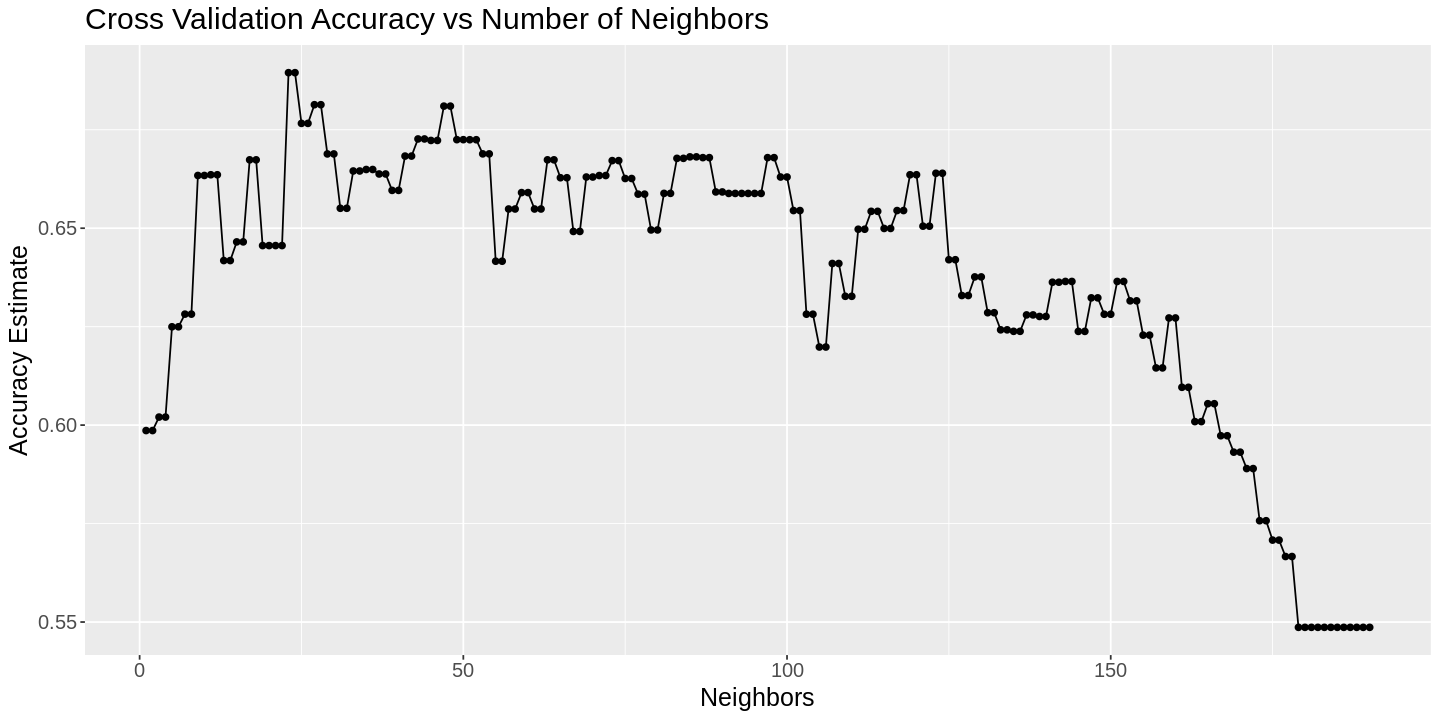

In [7]:
# Visualize k accuracy 
cross_val_plot <- accuracies_lots |> # accuracies
                ggplot(aes(x= neighbors, y = mean))+
                geom_point() +
                geom_line() +
                labs(x= "Neighbors", y = "Accuracy Estimate")+
                ggtitle("Cross Validation Accuracy vs Number of Neighbors")+
                theme(text = element_text(size = 15)) 
cross_val_plot


talk about cross val plot 
CAITLYN 

## Determining Best K


In [12]:
# Creating K-nearest neighbor model specification with 23 neighbors
spec_best_k <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
        set_engine("kknn") |>
        set_mode("classification") 
# Defining workflow using spec_best_k and fitting to training data 
knn_best_results <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(spec_best_k) |>
                fit(data = heart_training)
# Generating predictions to be used in confusion matrix
heart_predictions <- predict(knn_best_results, heart_testing) |>
                    bind_cols(heart_testing) |>
                    select(diagnosis, .pred_class)


# Mutating accuracies_lots to show % accuracy
heart_best_k <- accuracies_lots |>
        mutate(mean = 100*mean)|>
        arrange(desc(mean))

head(heart_best_k)

neighbors,mean
<int>,<dbl>
23,68.94928
24,68.94928
27,68.13570
28,68.13570
47,68.09947
48,68.09947


It is clear from the table that the K value which provides the highest accuracy of 68.95% is given by 23 neighbors.

In [10]:
# Finding the % of majority classifier
heart_major <- heart_training |>
            group_by(diagnosis) |>
            summarise(n=n()) |>
            mutate(percent = 100*n/nrow(heart_training))

heart_major

diagnosis,n,percent
<fct>,<int>,<dbl>
FALSE,124,54.86726
TRUE,102,45.13274


The majority classifier of our data set is 54.87% of patients having no diagnosis of heart disease. Our model using 23 neighbors provides us an accuracy of 68.95%. We observe a 25.66% relative increase over the baseline.

In [13]:
# Confusion matrix of K nearest neighbors using K=23
heart_conf_mat <- heart_predictions |>
                conf_mat(truth = diagnosis, estimate = .pred_class)

heart_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE    36   16
     TRUE      4   21

From our confusion matrix, our model shows:

|           | % |
|-----------|---|
| Accuracy  |  74.03 |
| Precision |  56.76 |
| Recall    |  84 |

From the confusion matrix, we observe a noticeable difference between the precision and recall. In the context of our heart disease diagnosis, prioritizing a higher recall makes sense as we want to minimize the risk of missing true positive cases. Even though our approach may include more false positive, further testing can ensure that afflicted patients receive the necessary care.

In [ ]:
# check for over/underfitting using resting bp vs age b/c it showed good differences 

# recall, model knn_best_results 

# trestbp vs age chosen b/c showed the most distinct differences between variables 

#fit it to the grid to get predictions 
# grid = 
# seq generates the range of the function - starting at min of thalach and then maximum in intervals of 100

# fit variables to grid. grid is so that it can be visualized in the graph 
# fitting training model onto this grid to give us every predicition 
# plot grid points according to estimating 

# Select columns thalach and age from the training dataset

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe_2 <- recipe(diagnosis ~ chol + thalach, data = heart_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
knn_fitted <- workflow() |>
        add_recipe(heart_recipe_2) |>
        add_model(knn_spec_2) |>
        fit(data = heart_training)

thalach_grid <- seq(min(heart_training$thalach), 
                max(heart_training$thalach), 
                length.out = 100)

chol_grid <- seq(min(heart_training$chol), 
                max(heart_training$chol), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(thalach = thalach_grid,
                                chol = chol_grid))
# Use the fitted workflow generated earlier to make predictions at the grid points 
knnPredGrid <- predict(knn_fitted, asgrid)

prediction_heart_table <- bind_cols(knnPredGrid, asgrid) |>
                        rename(diagnosis = .pred_class)

# Generate a plot, coloring the scatter points from the original data and including a faded colored scatter for the grid points. 


wkflw_plot <- ggplot() +
geom_point(data = heart_training, mapping = aes(x= chol, y= thalach, color = diagnosis), alpha = 0.75) +
geom_point(data = prediction_heart_table, mapping = aes(x=chol, y=thalach, color =diagnosis), alpha = 0.06, size = 5) +
labs(color = "Diagnosis", x = "Chol", y = "Resting Blood Pressure \n (mm Hg)") +
scale_color_manual(values = c("darkorange", "steelblue")) +
theme(text = element_text(size = 12))
wkflw_plot


CAITLYN explain orange blue graph 

RITZ EXPLAIN ALL OF SWITZERLAND

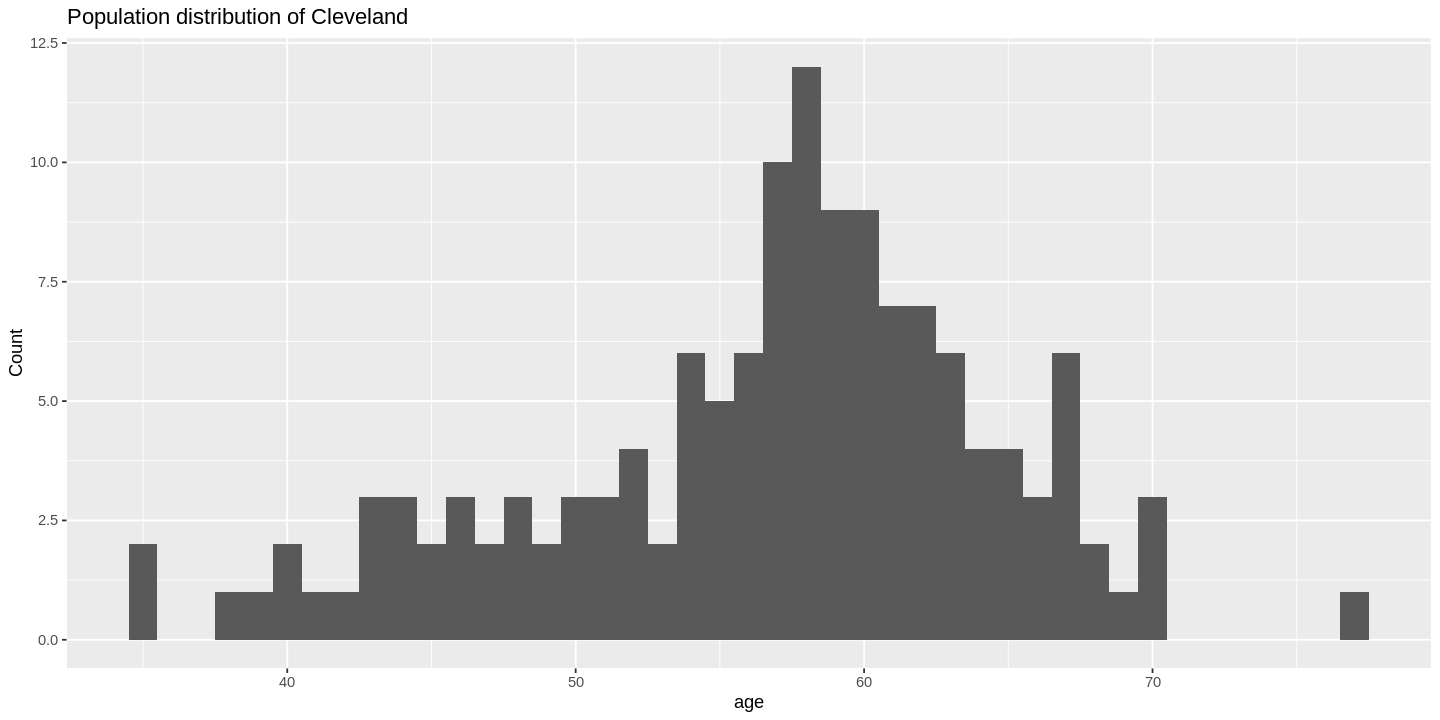

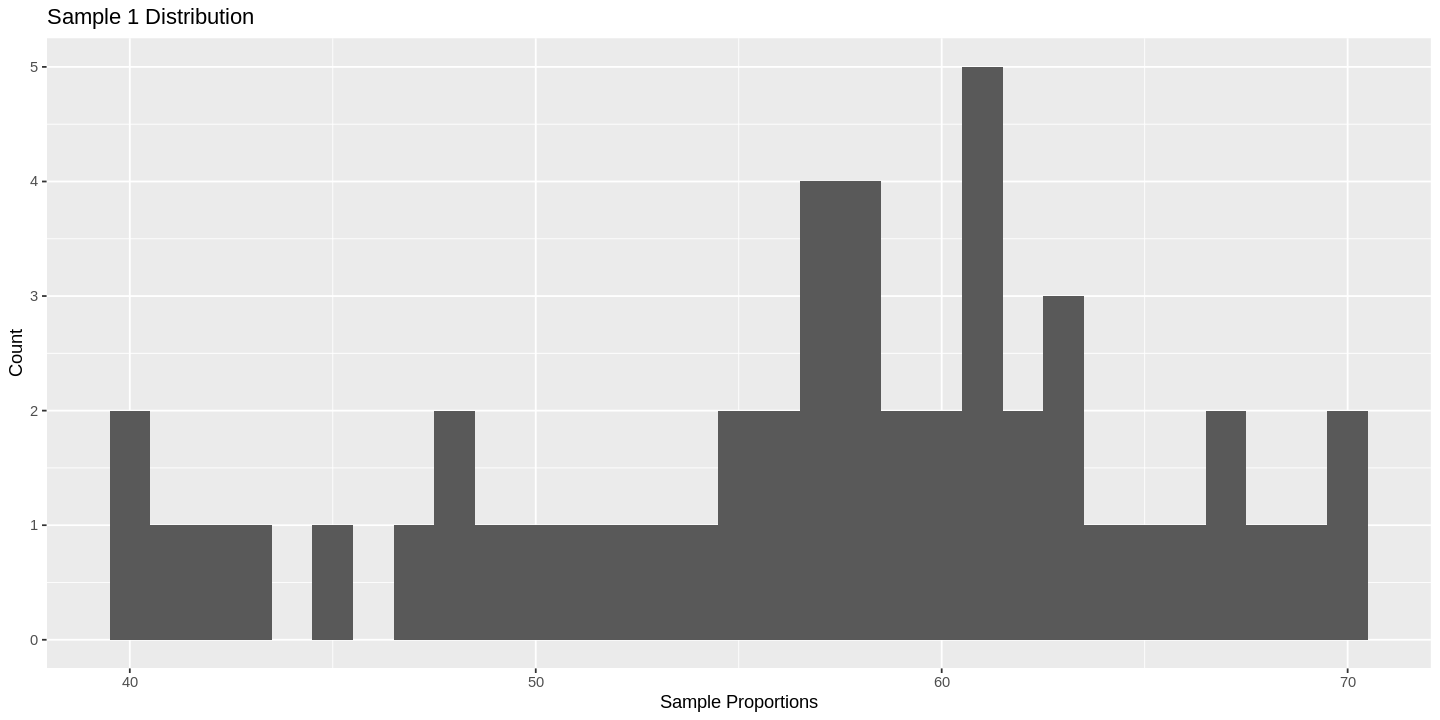

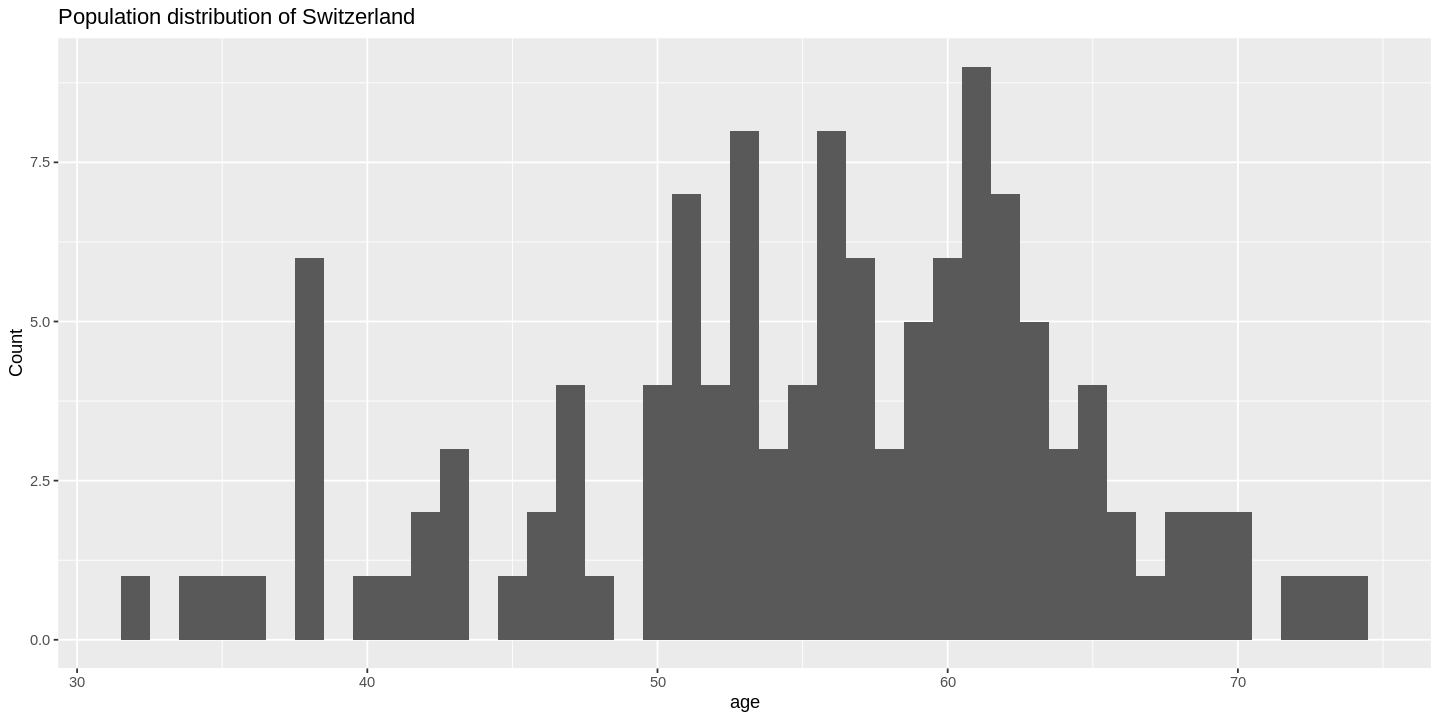

[1] "pop_parameters_cleveland"


pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
56.6259,58,7.938416


[1] "sample_1_cleveland_estimates"


pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
56.94,58,7.998495


[1] "pop_parameters_switzerland"


pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
55.36522,57,8.965167


[1] "sample_1_switzerland_estimates"


pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
56.94,58,7.998495


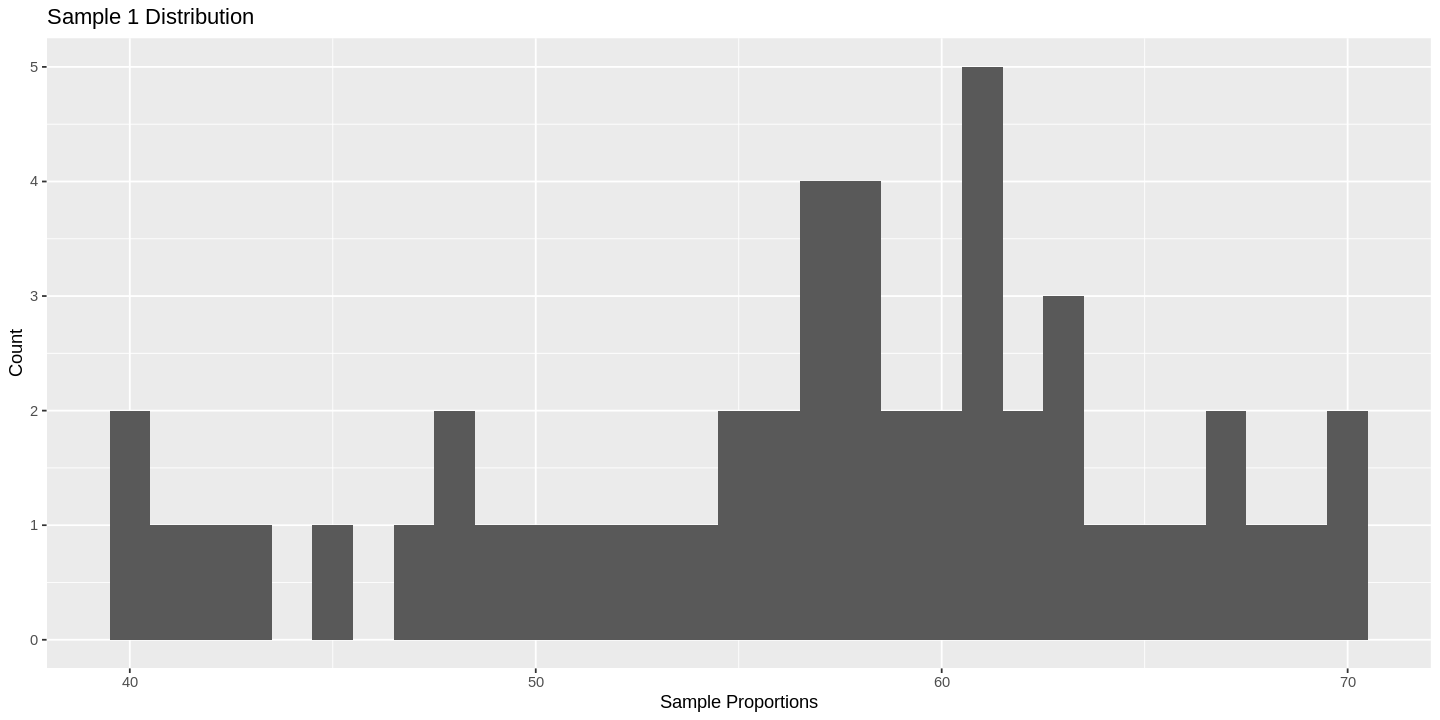

In [14]:
#checking consistency of our classifier using an additional data set from the data base
#switzerland 
# cross compare the cleveland dataset to the swiss one to see if the model is consistent 

#load tidied swiss data 
# ritz ode 

#checking consistency of our classifier using an additional data set from the data base
#cleveland
heart_data_clean2 <- heart_data_clean |>
    filter(diagnosis == "TRUE")

pop_dist <- ggplot(heart_data_clean2 , aes(x = age)) + 
    geom_histogram(binwidth = 1) +
    labs(x = "age", y = "Count") +
    ggtitle("Population distribution of Cleveland")

pop_parameters_cleveland <- heart_data_clean2 |>
    summarize(pop_mean = mean(age), 
              pop_med = median(age), 
              pop_sd = sd(age))

sample_1_cleveland <- heart_data_clean2 |> 
    rep_sample_n(50)

sample_1_dist_cleveland <- sample_1_cleveland|>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Sample Proportions", y = "Count") +
    ggtitle("Sample 1 Distribution")


sample_1_cleveland_estimates <- sample_1_cleveland |>
    summarize(pop_mean = mean(age), 
              pop_med = median(age), 
              pop_sd = sd(age))


pop_dist
sample_1_dist_cleveland
#checking consistency of our classifier using an additional data set from the data base
#switzerland
switzerland_data_clean2 <- switzerland_data_clean |>
    filter(diagnosis == "TRUE")

pop_dist2 <- ggplot(switzerland_data_clean, aes(x = age)) + 
    geom_histogram(binwidth = 1) +
    labs(x = "age", y = "Count") +
    ggtitle("Population distribution of Switzerland")

pop_parameters_switzerland <- switzerland_data_clean2 |>
    summarize(pop_mean = mean(age), 
              pop_med = median(age), 
              pop_sd = sd(age))

sample_1_switzerland <- heart_data_clean2 |> 
    rep_sample_n(50)

sample_1_dist_switzerland <- sample_1_cleveland|>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 1) +
    labs(x = "Sample Proportions", y = "Count") +
    ggtitle("Sample 1 Distribution")


sample_1_switzerland_estimates <- sample_1_cleveland |>
    summarize(pop_mean = mean(age), 
              pop_med = median(age), 
              pop_sd = sd(age))

pop_dist2
sample_1_dist_switzerland
# cross compare the cleveland dataset to the swiss one to see if the model is consistent
print ("pop_parameters_cleveland")
pop_parameters_cleveland
print ("sample_1_cleveland_estimates")
sample_1_cleveland_estimates |> select(-replicate)
print ("pop_parameters_switzerland")
pop_parameters_switzerland
print ("sample_1_switzerland_estimates")
sample_1_switzerland_estimates |> select(-replicate)

FARIDA 

discussion section to address
- answering/how we answered the question (predictor/class variables) 
- expected findings compared to outcome and plausible reasoning for this (faridas notes) and relate to classifiers 68% accuracy... and if the classifier is good for cleaveland as it is for switzerland 
- impact of findings
- future questions 


    1. summarize what we found
    2. significance 
    3. discuss whether this is what we expected
    4. dicuss impact
       

 heading here 
Future questions this could lead to: 
1. Which of the factors have the greatest influence on diagnosis of CAD?
2. What are some preventative measures one can take to minimize risk of heart disease?






### Bibliography ### 

Detrano, R., Janois, A., Steinbrunn, W., Pfisterer, Matthias., Schmid, Johann-Jakob., Sandhu, S., Guppy, KH., Lee, S., Froelicher, V. (1988). International Application of a New Probability Algorithm for the Diagnosis of Coronary Artery Disease. *The American Journal of Cardiology*, 64(1), 304-309.  https://doi.org/10.24432/C52P4X.

Coronary Artery Disease. (2021, July 19). Centers for Disease Control and Prevention (CDC). https://www.cdc.gov/heartdisease/coronary_ad.htm


Janosi, A ., Steinbrunn, W., Pfisterer, M., and Detrano, R. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

World Health Organization. (n.d.). https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1. 

